In [1]:
!pip install torch==2.0.0+cu117 torchvision==0.15.1+cu117 torchaudio==2.0.1 --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 925.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 93.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lit: filename=lit-15.0.7-py3-none-any.whl size=89989 sha256=433911c066c6314bed401721d6413497fecc3d62ecb5a6b02122a20814de819a
  Stored in directory: /root/.cache/pip/wheels/27/2c/b6/3ed2983b1b44fe0dea1bb35234b09f2c22fb8ebb308679c922
Successfully built lit
  Attempting uninstall: triton
    Found existing installation: triton 2.1.0
    Uninstalling triton-2.1.0:
      Successfully uninstalled triton-2.1.0
  Attempting uninstall: torch
    Found existing installation: torch 2.

In [2]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install scikit-learn

## I. MNIST Data

### Exercice 1 : Loading Data

In [21]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from copy import deepcopy
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, TensorDataset

import numpy as np
import matplotlib.pyplot as plt

1)Create a function iid_split. This function should take a dataset, nb_nodes, n_samples_per_node, batch_size, and shuffle as parameters. The goal is to divide the dataset into nb_nodes subsets (i.i.d.) and load each subset using PyTorch's DataLoader with the specified batch_size and shuffle, and then return a list of these DataLoaders.

Steps:
Load Data: Use DataLoader to load n_samples_per_node from the dataset with shuffle.  
Split Data: Divide the loaded data into nb_nodes i.i.d subsets, create a DataLoader for each, and append it to a list.   
Return List: Return the list of DataLoaders created.   

In [30]:
def iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle):
  loader = DataLoader(dataset, batch_size=n_samples_per_node, shuffle=shuffle)
  res = []
  it = iter(loader)
  for i in range(nb_nodes):
    img, labels = next(it)
    data_loader = DataLoader(TensorDataset(img, labels), batch_size=batch_size, shuffle=shuffle)
    res.append(data_loader)
  return res


2) Create a function non_iid_split, designed to divide a dataset non-i.i.d. It will receive parameters: dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, and shuffle_digits.

Steps:
Arrange Digits: Optionally shuffle digits and fairly split them among nb_nodes.  
Load Data: Utilize DataLoader to load nb_nodes*n_samples_per_node samples, considering the shuffle parameter.   
Split Data and Return: Create DataLoaders for each node containing samples with corresponding digits and append them to a list.   

In [34]:
def non_iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, shuffle_digits=False):
    assert(nb_nodes>0 and nb_nodes<=10)

    digits=torch.arange(10) if shuffle_digits==False else torch.randperm(10, generator=torch.Generator().manual_seed(0))

    # split the digits in a fair way
    #### Fixed ####
    split = []
    for i in range(0, 10, nb_nodes):
        if i + nb_nodes > 10:
            break
        split.append(digits[i:i+nb_nodes])

    # load and shuffle nb_nodes*n_samples_per_node from the dataset
    loader = torch.utils.data.DataLoader(dataset,
                                        batch_size=nb_nodes*n_samples_per_node,
                                        shuffle=shuffle)
    dataiter = iter(loader)
    images_train_mnist, labels_train_mnist = next(dataiter)

    data_splitted=list()
    for i in range(nb_nodes):
        # get indices for the digits, i.e. a tensor of boolean values correponding to idx of elements to keep in images_train_mnist and labels_train_mnist
        ### Fixed ###
        images, labels = next(dataiter)
        mask = np.isin(labels, split[i])
        images_masked = images[mask]
        labels_masked = labels[mask]
        # append data_splitted with current data loader
        ### Fixed ###
        load_data = TensorDataset(images_masked, labels_masked)
        data_splitted.append(DataLoader(dataset=load_data, batch_size=batch_size, shuffle=shuffle))

    # return data_splitted with all data loaders
    return data_splitted

3) Create a function get_MNIST, that fetches the MNIST dataset and utilizes either iid_split or non_iid_split to return train and test DataLoaders. The parameters are type ("iid" or "non_iid"), n_samples_train, n_samples_test, n_clients, batch_size, and shuffle.

Steps:
Load MNIST Dataset: Utilize the MNIST dataset from PyTorch datasets for both train and test.  
Apply Split Function: Depending on the type parameter, apply either iid_split or non_iid_split to the loaded datasets.   
Return DataLoaders: Return the created train and test DataLoaders lists.  


In [35]:
def get_MNIST(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True):
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
    if type=="iid":
        train_loader = iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle)
        test_loader = iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle)
        return train_loader, test_loader
    elif type == "non_iid":
        train_loader = non_iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle)
        test_loader = non_iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle)
        return train_loader, test_loader
    raise Exception('illegal argument', 'getMNIST')

4) Use get_MNIST to get mnist_iid_train and mnist_iid_test dataloaders.

In [36]:
mnist_iid_train, mnist_iid_test = get_MNIST(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True)
mnist_non_iid_train, mnist_non_iid_test = get_MNIST(type="non_iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True)

5) Giving the following function plot_samples for iid data. Plot image samples of client 1, 2 and 3.

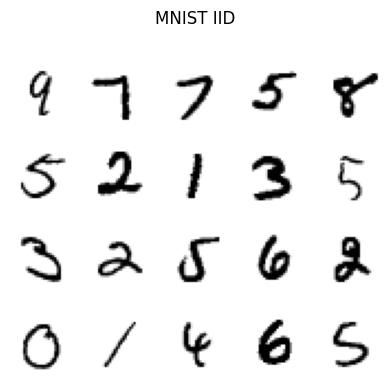

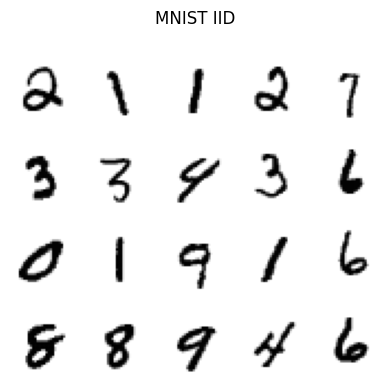

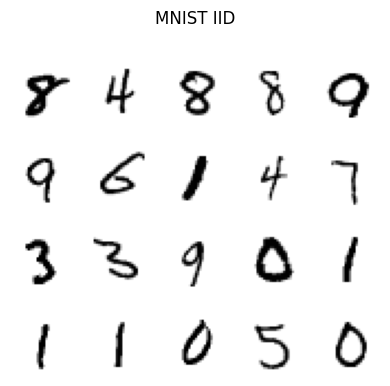

In [40]:
def plot_samples(data, channel:int, title=None, plot_name="", n_examples =20):

    n_rows = int(n_examples / 5)
    plt.figure(figsize=(1* n_rows, 1*n_rows))
    if title: plt.suptitle(title)
    X, y= data
    for idx in range(n_examples):

        ax = plt.subplot(n_rows, 5, idx + 1)

        image = 255 - X[idx, channel].view((28,28))
        ax.imshow(image, cmap='gist_gray')
        ax.axis("off")

    if plot_name!="":plt.savefig(f"plots/"+plot_name+".png")

    plt.tight_layout()

data_iter = iter(mnist_iid_train[0])
images, labels = next(data_iter)
plot_samples((images, labels), 0, title="MNIST IID", plot_name="mnist_iid_train")
images, labels = next(data_iter)
plot_samples((images, labels), 0, title="MNIST IID", plot_name="mnist_iid_train")
images, labels = next(data_iter)
plot_samples((images, labels), 0, title="MNIST IID", plot_name="mnist_iid_train")

6) Plot samples this time for non_iid data for 3 clients.

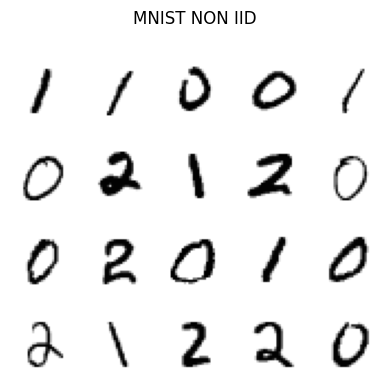

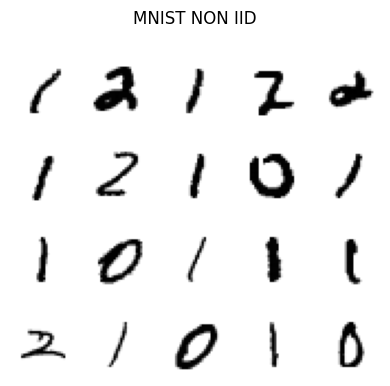

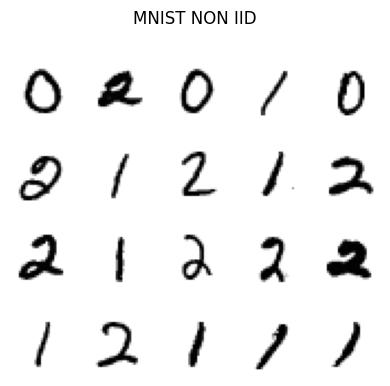

In [43]:
data_iter = iter(mnist_non_iid_test[0])
images, labels = next(data_iter)
plot_samples((images, labels), 0, title="MNIST NON IID", plot_name="mnist_non_iid_test")
images, labels = next(data_iter)
plot_samples((images, labels), 0, title="MNIST NON IID", plot_name="mnist_non_iid_test")
images, labels = next(data_iter)
plot_samples((images, labels), 0, title="MNIST NON IID", plot_name="mnist_non_iid_test")

### Exercice 2 : FedAvg and FedProx Implementation

Here is a simple CNN.

In [44]:
class CNN(nn.Module):

    """ConvNet -> Max_Pool -> RELU -> ConvNet ->
    Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

model_0 = CNN()

1) Create a function difference_models_norm_2(model_1, model_2) which take two models, get models parameters and returns the sum of the square differences of models parameters.





In [45]:
def difference_models_norm_2(model_1, model_2):
    """Return the norm 2 difference between the two model parameters
    """
    norm_2 = 0
    for param_1, param_2 in zip(model_1.parameters(), model_2.parameters()):
        norm_2 += torch.norm(param_1 - param_2, 2)**2
    return norm_2

Here is the function to perform one epoch of training data.

In [46]:
def train_step(model, model_0, mu:int, optimizer, train_data, loss_f):
    """Train `model` on one epoch of `train_data`"""

    total_loss=0

    for idx, (features,labels) in enumerate(train_data):

        optimizer.zero_grad()

        predictions= model(features)

        loss=loss_f(predictions,labels)
        loss+=mu/2*difference_models_norm_2(model,model_0)
        total_loss+=loss

        loss.backward()
        optimizer.step()

    return total_loss/(idx+1)

2) Create a function local_learning which perform a local training of a model sent. We need to precise number of epochs needed to be performed locally. Use previous function defined.

Return the local_loss compute during local training.

In [47]:
def local_learning(model, mu:float, optimizer, train_data, epochs:int, loss_f):

    ### Copy model to a new variable ###
    ### Fixed ###
    model_copy= deepcopy(model)
    for epoch in range(epochs):
        local_loss=train_step(model, model_copy, mu, optimizer, train_data, loss_f)

    return float(local_loss.detach().numpy())

We defined 4 others usefull functions :
- loss_classifier :
- loss_dataset :
- accuracy_dataset :
- set_to_zero_model_weights :

Take time to read it.

In [48]:
def loss_classifier(predictions,labels):

    m = nn.LogSoftmax(dim=1)
    loss = nn.NLLLoss(reduction="mean")

    return loss(m(predictions) ,labels.view(-1))


def loss_dataset(model, dataset, loss_f):
    """Compute the loss of `model` on `dataset`"""
    loss=0

    for idx,(features,labels) in enumerate(dataset):

        predictions= model(features)
        loss+=loss_f(predictions,labels)

    loss/=idx+1
    return loss


def accuracy_dataset(model, dataset):
    """Compute the accuracy of `model` on `dataset`"""

    correct=0

    for features,labels in iter(dataset):

        predictions= model(features)

        _,predicted=predictions.max(1,keepdim=True)

        correct+=torch.sum(predicted.view(-1,1)==labels.view(-1, 1)).item()

    accuracy = 100*correct/len(dataset.dataset)

    return accuracy

def set_to_zero_model_weights(model):
    """Set all the parameters of a model to 0"""

    for layer_weigths in model.parameters():
        layer_weigths.data.sub_(layer_weigths.data)

3) Defined a function average_models, which as it is written average parameters of a list of models to create a new model.


In [49]:
def average_models(model, clients_models_hist:list , weights:list):


    """Creates the new model of a given iteration with the models of the other
    clients"""

    new_model=deepcopy(model)
    set_to_zero_model_weights(new_model)

    for k,client_hist in enumerate(clients_models_hist):

        for idx, layer_weights in enumerate(new_model.parameters()):

            contribution=client_hist[idx].data*weights[k]
            layer_weights.data.add_(contribution)

    return new_model

4) We will now code a function to perform FedProx.

In [50]:
def FedProx(model, training_sets:list, n_iter:int, testing_sets:list, mu=0,
    file_name="test", epochs=5, lr=10**-2, decay=1):
    """ all the clients are considered in this implementation of FedProx
    Parameters:
        - `model`: common structure used by the clients and the server
        - `training_sets`: list of the training sets. At each index is the
            training set of client "index"
        - `n_iter`: number of iterations the server will run
        - `testing_set`: list of the testing sets. If [], then the testing
            accuracy is not computed
        - `mu`: regularization term for FedProx. mu=0 for FedAvg
        - `epochs`: number of epochs each client is running
        - `lr`: learning rate of the optimizer
        - `decay`: to change the learning rate at each iteration

    returns :
        - `model`: the final global model
    """

    loss_f=loss_classifier

    #Variables initialization
    K=len(training_sets) #number of clients
    n_samples=sum([len(db.dataset) for db in training_sets])
    weights=([len(db.dataset)/n_samples for db in training_sets])
    print("Clients' weights:",weights)


    loss_hist=[[float(loss_dataset(model, dl, loss_f).detach())
        for dl in training_sets]]
    acc_hist=[[accuracy_dataset(model, dl) for dl in testing_sets]]
    server_hist=[[tens_param.detach().numpy()
        for tens_param in list(model.parameters())]]
    models_hist = []


    server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
    server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])
    print(f'====> i: 0 Loss: {server_loss} Server Test Accuracy: {server_acc}')

    for i in range(n_iter):

        clients_params=[]
        clients_models=[]
        clients_losses=[]

        for k in range(K):

            local_model=deepcopy(model)
            # Define optimizer for local_model, don't forget the learning rate !
            local_optimizer=torch.optim.SGD(local_model.parameters(),lr=lr)
            # compute local_loss by performing learning steps on the current model
            local_loss=local_learning(local_model, mu, local_optimizer, training_sets[k], epochs, loss_f)

            clients_losses.append(local_loss)

            #GET THE PARAMETER TENSORS OF THE MODEL
            list_params=list(local_model.parameters())
            list_params=[tens_param.detach() for tens_param in list_params]
            clients_params.append(list_params)
            clients_models.append(deepcopy(local_model))


        #CREATE THE NEW GLOBAL MODEL
        # Create new global model by avering all locals models
        model = average_models(model, clients_params, weights)
        models_hist.append(clients_models)

        #COMPUTE THE LOSS/ACCURACY OF THE DIFFERENT CLIENTS WITH THE NEW MODEL
        loss_hist+=[[float(loss_dataset(model, dl, loss_f).detach())
            for dl in training_sets]]
        acc_hist+=[[accuracy_dataset(model, dl) for dl in testing_sets]]

        server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
        server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])

        print(f'====> i: {i+1} Loss: {server_loss} Server Test Accuracy: {server_acc}')


        server_hist.append([tens_param.detach().cpu().numpy()
            for tens_param in list(model.parameters())])

        #DECREASING THE LEARNING RATE AT EACH SERVER ITERATION
        lr*=decay

    return model, loss_hist, acc_hist

###  Exercice 3 : iid data

#### Fed training with FedAvg

1) With FedProx compute a FedAvg on iid data.

In [84]:
FedAvg_1 = FedProx(model_0, mnist_iid_train, 10, mnist_iid_test, epochs=2)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.300609588623047 Server Test Accuracy: 10.666666666666666
====> i: 1 Loss: 2.293616771697998 Server Test Accuracy: 12.666666666666666
====> i: 2 Loss: 2.2865275541941323 Server Test Accuracy: 15.0
====> i: 3 Loss: 2.278780221939087 Server Test Accuracy: 23.0
====> i: 4 Loss: 2.2700134913126626 Server Test Accuracy: 29.666666666666664
====> i: 5 Loss: 2.2600265343983965 Server Test Accuracy: 33.0
====> i: 6 Loss: 2.2482701142628985 Server Test Accuracy: 34.0
====> i: 7 Loss: 2.234050989151001 Server Test Accuracy: 36.0
====> i: 8 Loss: 2.216812928517659 Server Test Accuracy: 37.0
====> i: 9 Loss: 2.195621093114217 Server Test Accuracy: 39.33333333333333
====> i: 10 Loss: 2.1690910657246905 Server Test Accuracy: 43.33333333333333


2) Define a function plot_accuracy_loss to plot accuracy and loss of performed FedAvg for the 3 different clients.

In [80]:
def plot_acc_loss(title:str, loss_hist:list, acc_hist:list):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.title(title)
    plt.plot(loss_hist)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.title(title)
    plt.plot(acc_hist)
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")

    plt.tight_layout()

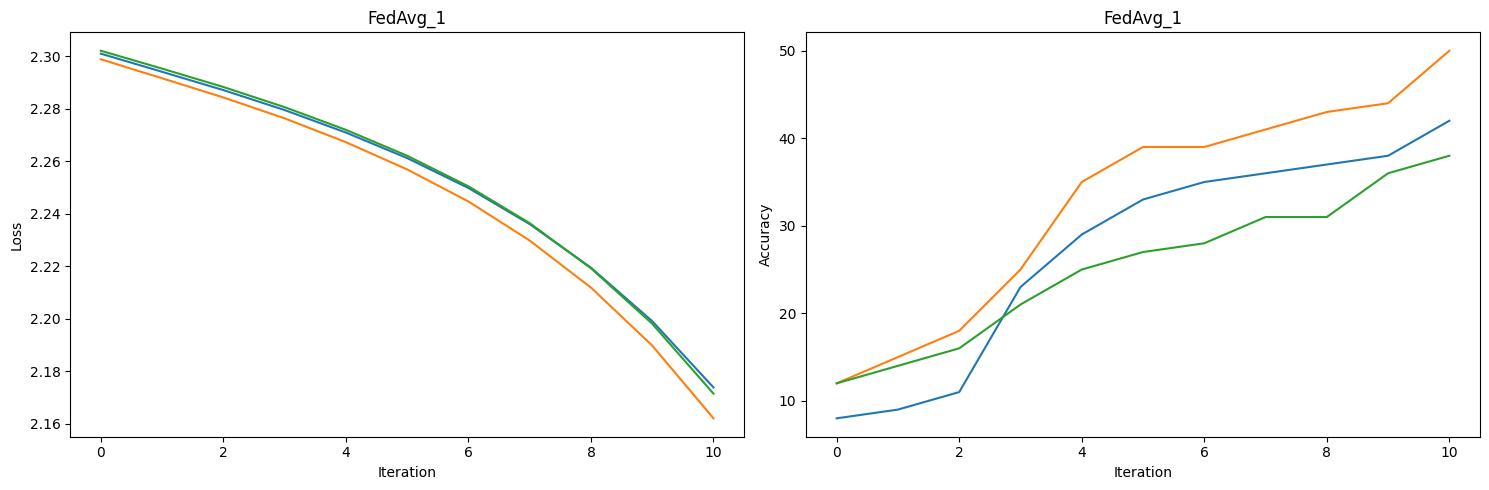

In [85]:
plot_acc_loss("FedAvg_1", FedAvg_1[1], FedAvg_1[2])

#### FedPRox

3) Do the same as for 1) and 2).
You can take 2 local epochs, a learning rate of 0.1, mu = 0.3 and 10 iterations.

In [82]:
FedProx_1 = FedProx(model_0, mnist_iid_train, 10, mnist_iid_test, epochs=2, lr=0.1, mu=0.3)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.300609747568766 Server Test Accuracy: 10.666666666666666
====> i: 1 Loss: 2.220925410588582 Server Test Accuracy: 45.666666666666664
====> i: 2 Loss: 1.8026564121246338 Server Test Accuracy: 41.0
====> i: 3 Loss: 1.3331534465154011 Server Test Accuracy: 58.666666666666664
====> i: 4 Loss: 0.6776096026102701 Server Test Accuracy: 72.33333333333333
====> i: 5 Loss: 0.4830682078997294 Server Test Accuracy: 79.0
====> i: 6 Loss: 0.32545203963915503 Server Test Accuracy: 83.33333333333333
====> i: 7 Loss: 0.24604877332846323 Server Test Accuracy: 84.66666666666666
====> i: 8 Loss: 0.1751008331775665 Server Test Accuracy: 89.66666666666666
====> i: 9 Loss: 0.15263627966245014 Server Test Accuracy: 89.66666666666666
====> i: 10 Loss: 0.12621749937534332 Server Test Accuracy: 89.0


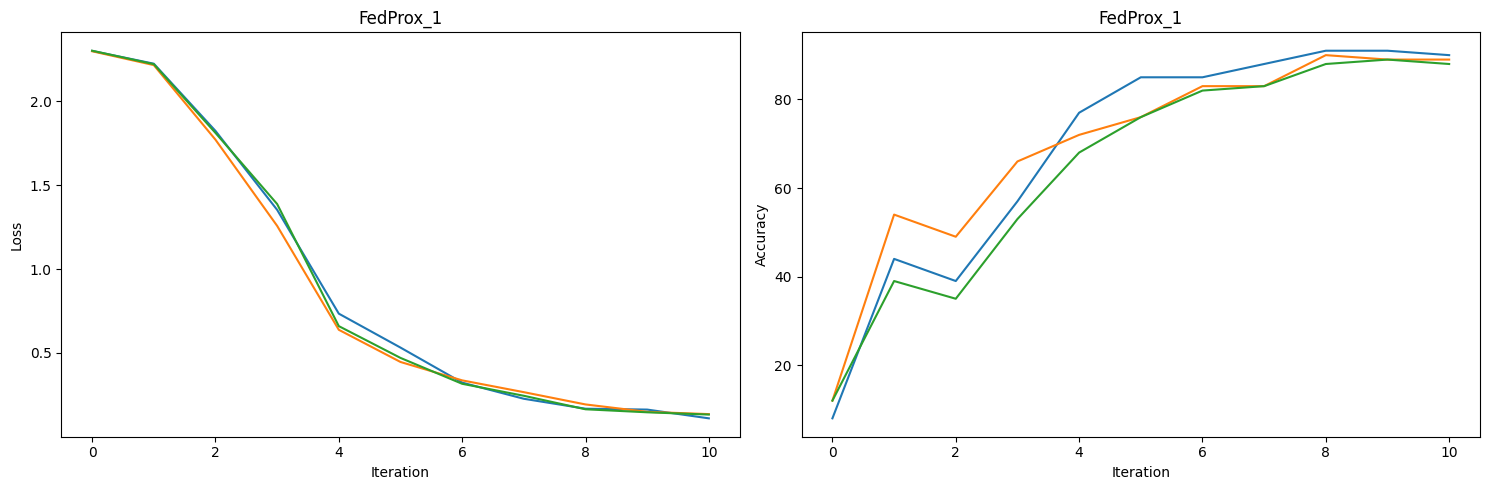

In [83]:
plot_acc_loss("FedProx_1", FedProx_1[1], FedProx_1[2])

4) What do you observe ?

FedProx and FedAvg are performing similarly if FedAvg has the learning to 0.1 as FedProx. Without this learning rate FedAvg performs significantly worse than FedProx.

### Exercice 4 : Non iid data

1) Perform a FedAvg on data and plot accuracy and loss
2) Do the same for a FedProx.

In [86]:
FedAvg_2 = FedProx(model_0, mnist_non_iid_train, 10, mnist_non_iid_test, epochs=2, lr=0.1)

Clients' weights: [0.36589698046181174, 0.3197158081705151, 0.31438721136767317]
====> i: 0 Loss: 2.292411661486854 Server Test Accuracy: 11.594089746842855
====> i: 1 Loss: 2.0257985799393055 Server Test Accuracy: 44.73861802005108
====> i: 2 Loss: 1.6548117574959411 Server Test Accuracy: 39.58892985189751
====> i: 3 Loss: 1.1868482974240453 Server Test Accuracy: 72.42133356561041
====> i: 4 Loss: 1.305407472020991 Server Test Accuracy: 50.949017944998644
====> i: 5 Loss: 0.9024418632683491 Server Test Accuracy: 75.45438478205021
====> i: 6 Loss: 0.6282574440192159 Server Test Accuracy: 80.65605932582409
====> i: 7 Loss: 0.49028854694078494 Server Test Accuracy: 85.0483869427147
====> i: 8 Loss: 0.4507237136046374 Server Test Accuracy: 89.55166151770771
====> i: 9 Loss: 0.9414270525503751 Server Test Accuracy: 71.68734986984852
====> i: 10 Loss: 0.41891055018186146 Server Test Accuracy: 87.11654739625301


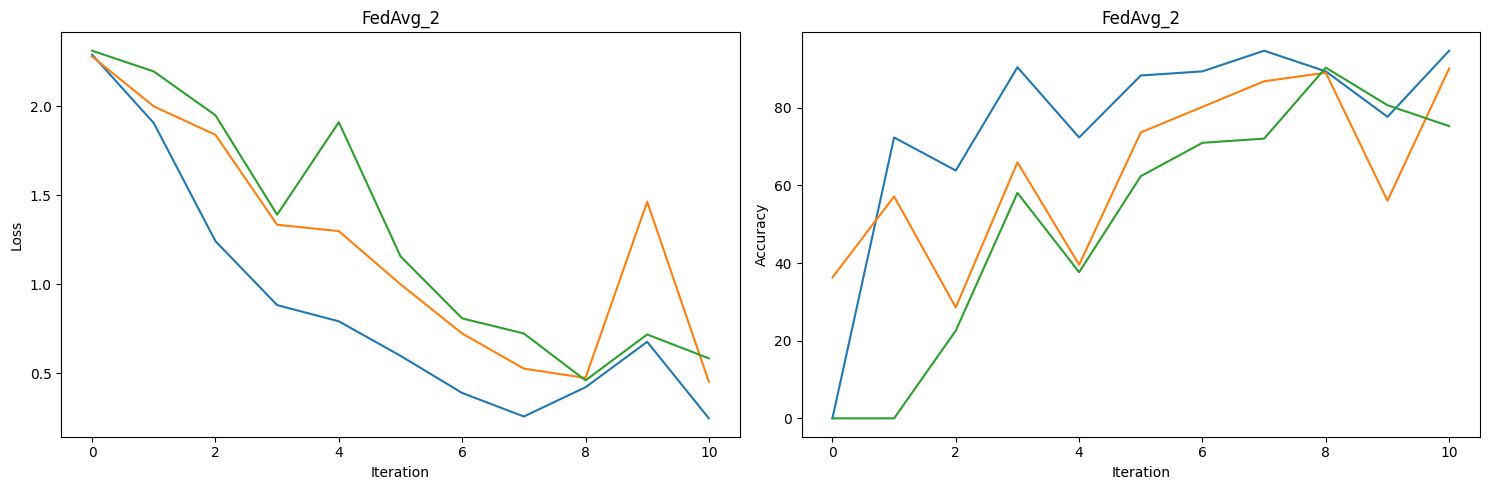

In [87]:
plot_acc_loss("FedAvg_2", FedAvg_2[1], FedAvg_2[2])

In [73]:
FedProx_2 = FedProx(model_0, mnist_non_iid_train, 10, mnist_non_iid_test, epochs=2, lr=0.1, mu=0.3)

Clients' weights: [0.36589698046181174, 0.3197158081705151, 0.31438721136767317]
====> i: 0 Loss: 2.2918173860275513 Server Test Accuracy: 11.594089746842855
====> i: 1 Loss: 2.162547789500831 Server Test Accuracy: 29.16288980856311
====> i: 2 Loss: 1.8565009745569043 Server Test Accuracy: 48.3817368430268
====> i: 3 Loss: 1.5007539650898418 Server Test Accuracy: 61.53185573476665
====> i: 4 Loss: 1.0520852643262006 Server Test Accuracy: 64.62939358119239
====> i: 5 Loss: 1.0754295900914004 Server Test Accuracy: 67.17039749000358
====> i: 6 Loss: 0.6898603101606691 Server Test Accuracy: 78.17954204699883
====> i: 7 Loss: 0.5778577608282994 Server Test Accuracy: 82.291232188159
====> i: 8 Loss: 0.478226668140181 Server Test Accuracy: 82.6710786272698
====> i: 9 Loss: 0.3895206378895266 Server Test Accuracy: 83.28463333723661
====> i: 10 Loss: 0.4123857894756866 Server Test Accuracy: 89.74318159753572


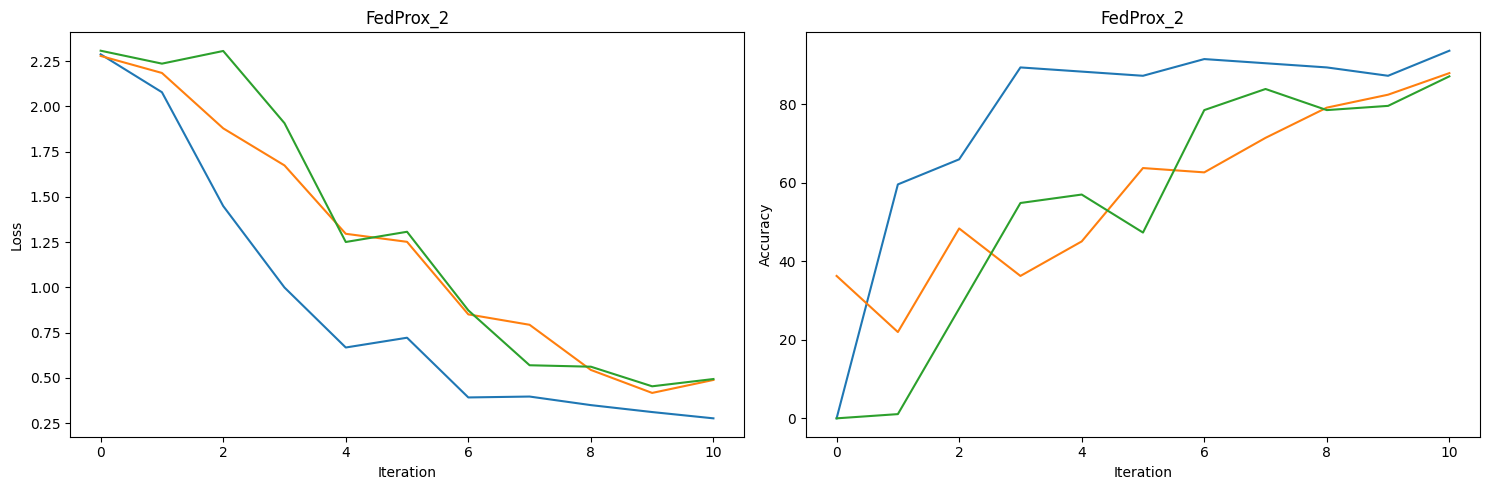

In [88]:
plot_acc_loss("FedProx_2", FedProx_2[1], FedProx_2[2])

2) What do you observe ?

With non_iid there is a big difference between each client. But with iid there is almost no difference between each client. And FedAvg's accuracy evolution seems much more erratic than of FedProx.

## II. Medical Data

### Exercice 5 : medmnist

For medical datasets we will use medmnist package.  
Medmnist is large-scale MNIST-like collection of standardized biomedical images, including 12 datasets for 2D and 6 datasets for 3D : https://medmnist.com/

In [75]:
! pip install medmnist


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=03e7711ea9b58f25d9e12e768ba68f57dde2d13fadb2dbbb31dbc1335da8d50d
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


Import medmnist

In [76]:
import medmnist

You can list all available datasets with this command

In [89]:
!python -m medmnist available

MedMNIST v2.2.3 @ https://github.com/MedMNIST/MedMNIST/
All available datasets:
	pathmnist
	chestmnist
	dermamnist
	octmnist
	pneumoniamnist
	retinamnist
	breastmnist
	bloodmnist
	tissuemnist
	organamnist
	organcmnist
	organsmnist
	organmnist3d
	nodulemnist3d
	adrenalmnist3d
	fracturemnist3d
	vesselmnist3d
	synapsemnist3d


We will use BloodMNIST for the following exercices. BloodMnist is a dataset with 8 categories of blood cells capture by microscope.

1. Import from medmnsit BloodMNIST

In [90]:
from medmnist import BloodMNIST

In [91]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

2. Create a preprocessing pipeline for data, transforms it into Tensor and then normalize it with a mean of 0.5 and standard deviation of 0.5 also.

In [92]:
preprocessing_pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

3. Create a train dataset and test dataset from data and apply previous preprocessing pipeline. You can use DataClass from pytorch to create datasets.

In [93]:
train_dataset = BloodMNIST(root='./data', split='train', download=True, transform=preprocessing_pipeline)
test_dataset = BloodMNIST(root='./data', split='test', download=True, transform=preprocessing_pipeline)

100%|██████████| 35461855/35461855 [00:01<00:00, 18130376.36it/s]


Using downloaded and verified file: ./data/bloodmnist.npz


4. Just to understand data print the 2 datasets to see differences with previous MNIST data.

In [95]:
print(train_dataset)
print(test_dataset)

Dataset BloodMNIST (bloodmnist)
    Number of datapoints: 11959
    Root location: ./data
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: CC BY 4.0
Dataset BloodM

5. Create a data loader for train data and test dat, you can use a batch size of 128 and shuffle data.

In [98]:
train_blood_mnist = DataLoader(train_dataset, shuffle=True, batch_size=128)
test_blood_mnist = DataLoader(test_dataset, shuffle=True, batch_size=128)

6. Modify previous functions non_iid_split, iid_split, get_MNIST and plot_samples to work with new data.  
a. non_iid_split : this time there are only 8 classes   
b. iid_split : nothing really changed  
c. get_MNIST : Like in 3. use train and test datasets with the preprocessing pipeline we defined previously.  
d. plot_samples : Make it work for this new images. Also try to print to which classes belong every images, to see later if your iid_split and non_iid_split work well.

In [140]:
def non_iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, shuffle_digits=False):
    assert(nb_nodes>0 and nb_nodes<=8)

    digits=torch.arange(8) if shuffle_digits==False else torch.randperm(8, generator=torch.Generator().manual_seed(0))

    # split the digits in a fair way
    #### Fixed ####
    split = []
    split_len = 8 // nb_nodes + 1
    for i in range(0, 8, split_len):
        split.append(digits[i:i+split_len])

    while len(split[-1]) < split_len:
        split[-1].concat(digits[np.random.randint(0, 8)])

    split = np.array(split)
    # load and shuffle nb_nodes*n_samples_per_node from the dataset
    loader = torch.utils.data.DataLoader(dataset,
                                        batch_size=nb_nodes*n_samples_per_node,
                                        shuffle=shuffle)
    dataiter = iter(loader)
    images_train_mnist, labels_train_mnist = next(dataiter)

    data_splitted=list()
    for i in range(nb_nodes):
        # get indices for the digits, i.e. a tensor of boolean values correponding to idx of elements to keep in images_train_mnist and labels_train_mnist
        ### Fixed ###
        images, labels = next(dataiter)
        mask = np.isin(labels, split[i])
        mask = mask.reshape(-1)
        images_masked = images[mask]
        labels_masked = labels[mask]
        # append data_splitted with current data loader
        ### Fixed ###
        load_data = TensorDataset(images_masked, labels_masked)
        data_splitted.append(DataLoader(dataset=load_data, batch_size=batch_size, shuffle=shuffle))

    # return data_splitted with all data loaders
    return data_splitted

In [120]:
def get_MNIST(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True):
    train_dataset = BloodMNIST(root='./data', split='train', download=True, transform=preprocessing_pipeline)
    test_dataset = BloodMNIST(root='./data', split='test', download=True, transform=preprocessing_pipeline)
    if type=="iid":
        train_loader = iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle)
        test_loader = iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle)
        return train_loader, test_loader
    elif type == "non_iid":
        train_loader = non_iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle)
        test_loader = non_iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle)
        return train_loader, test_loader
    raise Exception('illegal argument', 'getMNIST')

In [121]:
def plot_samples(data, channel:int, title=None, plot_name="", n_examples =20):

    n_rows = int(n_examples / 5)
    plt.figure(figsize=(1* n_rows, 1*n_rows))
    if title: plt.suptitle(title)
    X, y= data
    for idx in range(n_examples):

        ax = plt.subplot(n_rows, 5, idx + 1)

        image = 255 - X[idx, channel].view((28,28))
        ax.imshow(image, cmap='gist_gray')
        ax.axis("off")

    if plot_name!="":plt.savefig(f"plots/"+plot_name+".png")

    plt.tight_layout()

### Exercice 6 : Use federated learning on medical data

### IID data

1. Load train data and test data for 3 clients into IID datasets.

In [122]:
bloodmnist_iid_train, bloodmnist_iid_test = get_MNIST(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True)

Using downloaded and verified file: ./data/bloodmnist.npz
Using downloaded and verified file: ./data/bloodmnist.npz


2. plot samples with corresponding function.

<ipython-input-121-f438035f57fc>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(1* n_rows, 1*n_rows))


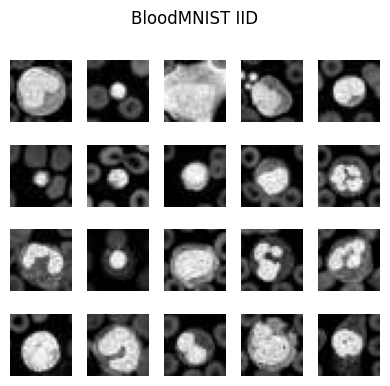

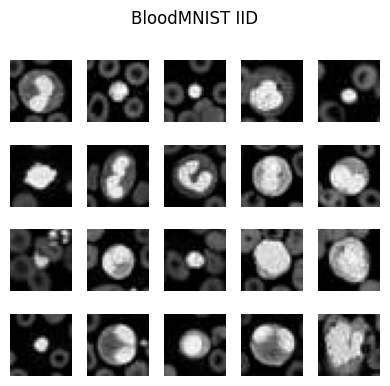

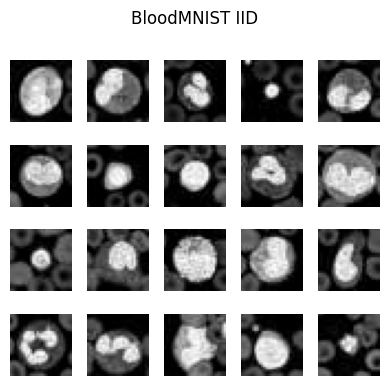

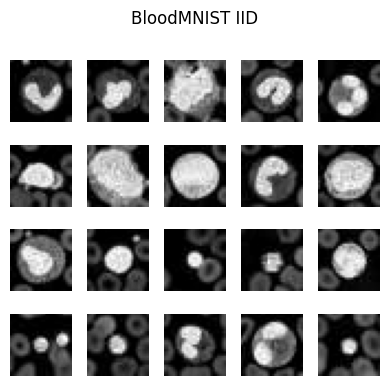

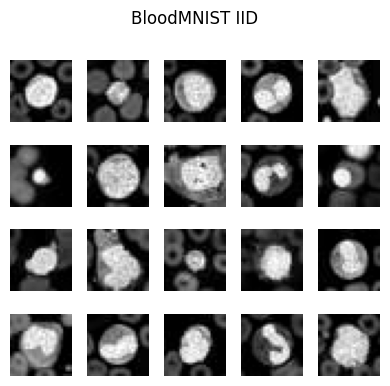

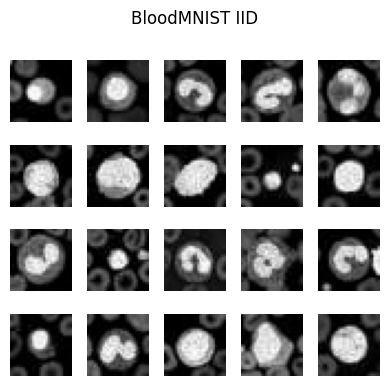

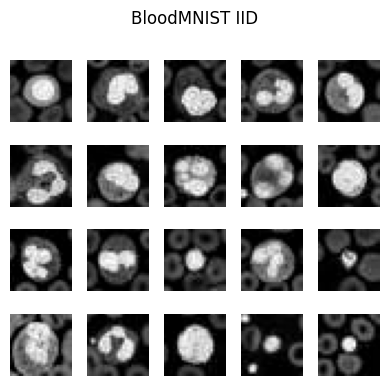

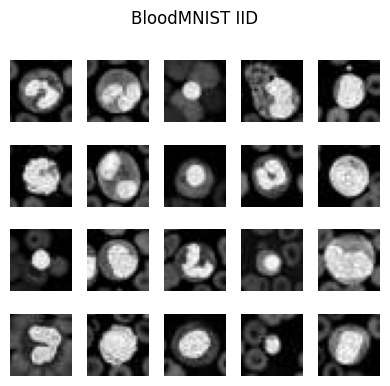

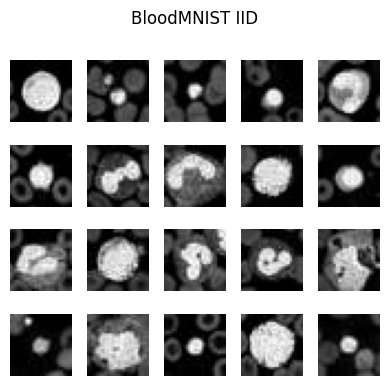

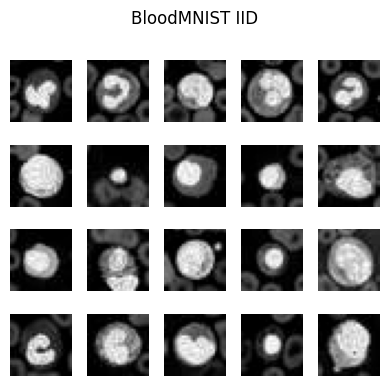

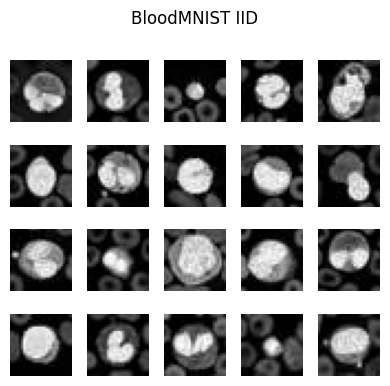

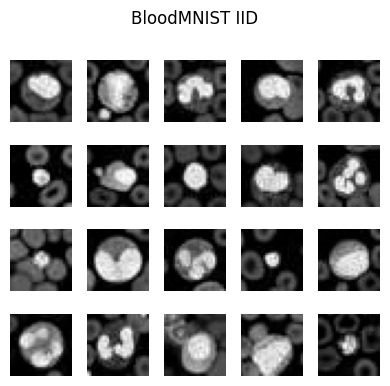

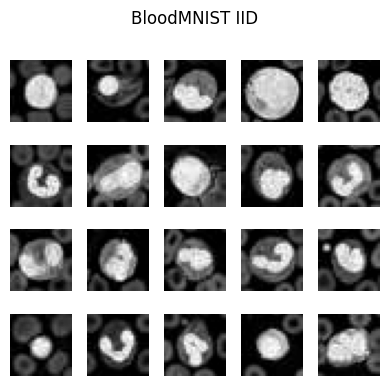

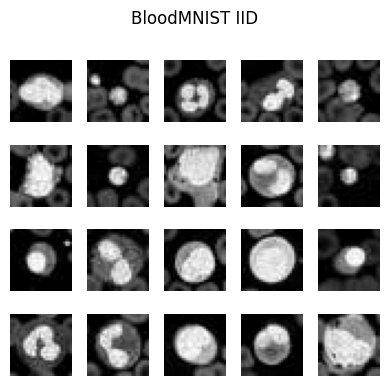

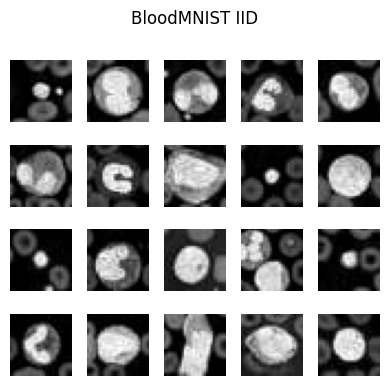

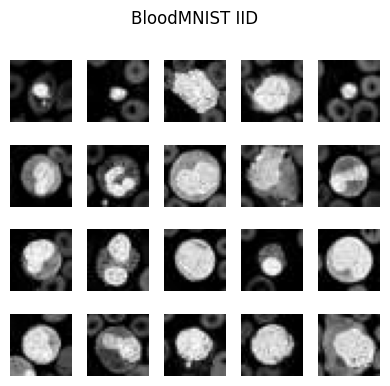

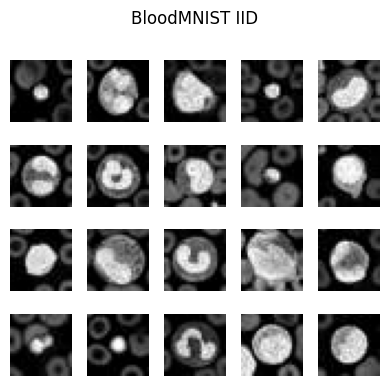

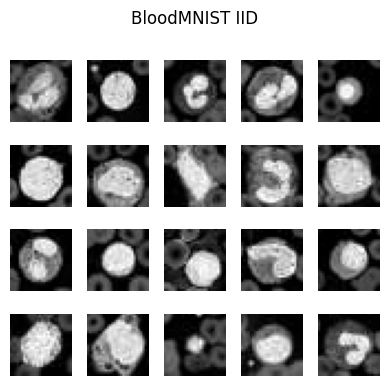

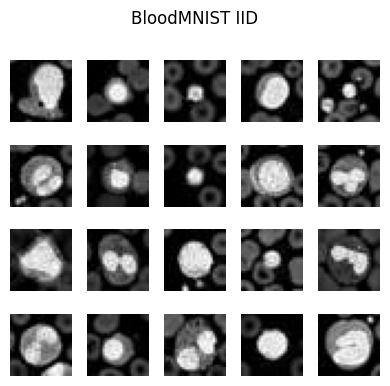

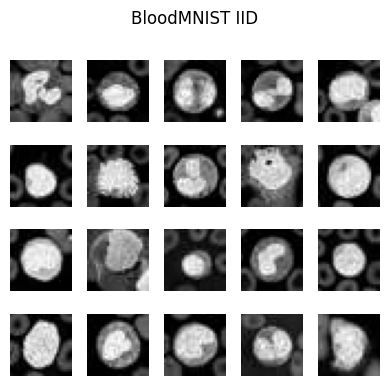

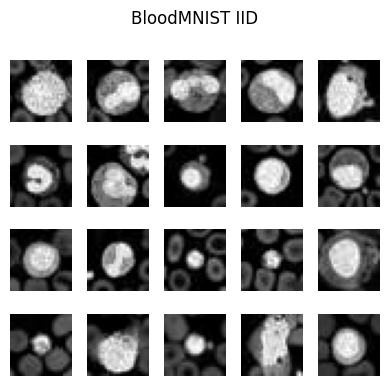

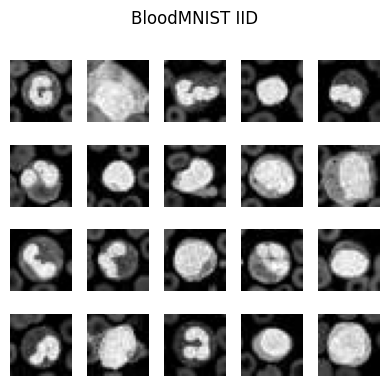

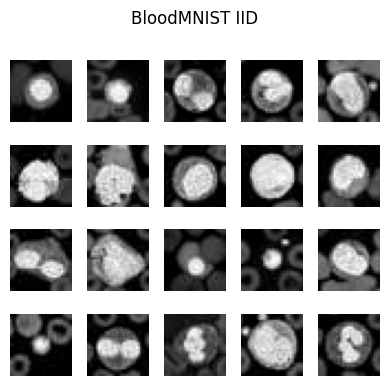

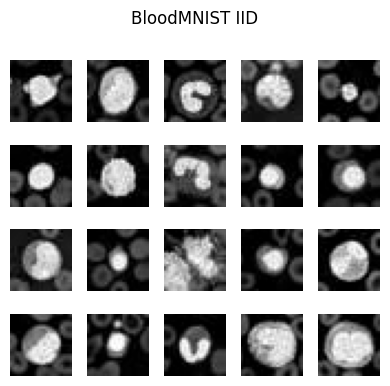

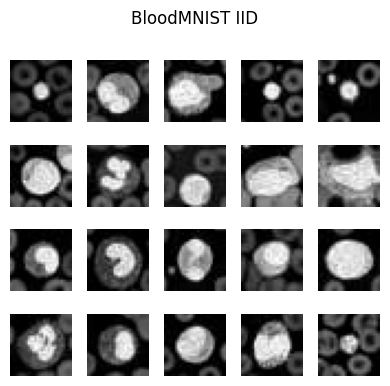

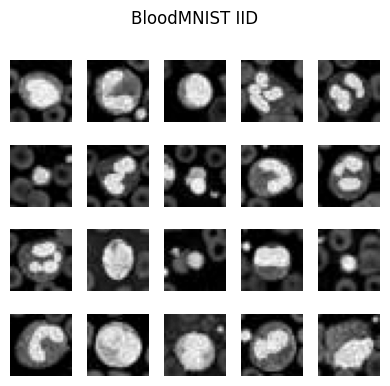

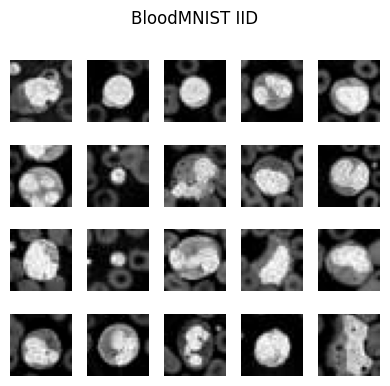

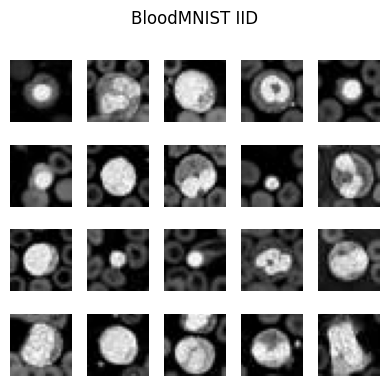

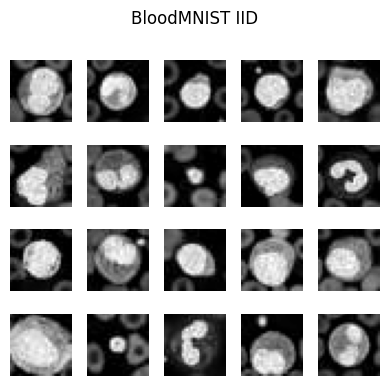

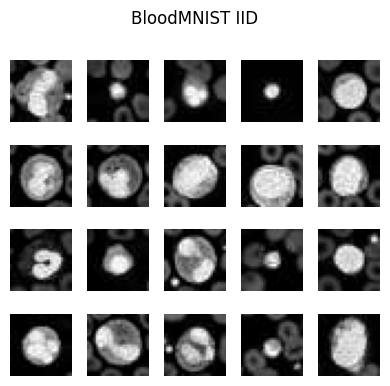

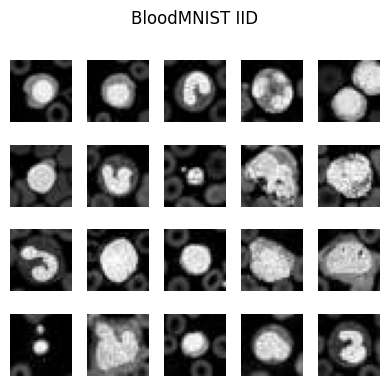

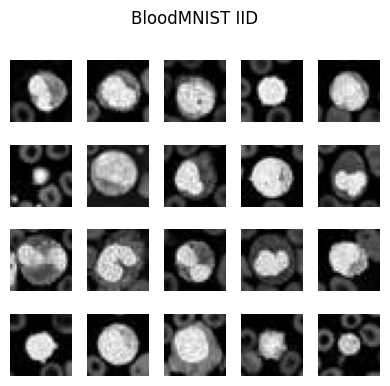

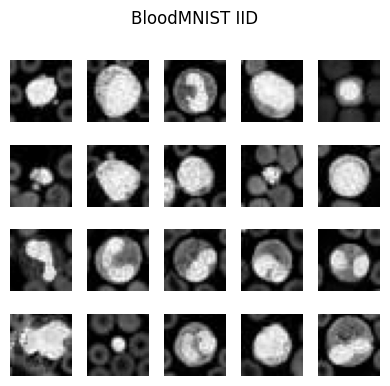

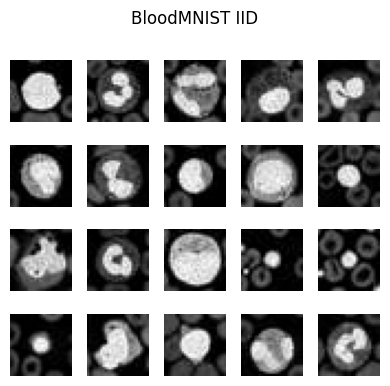

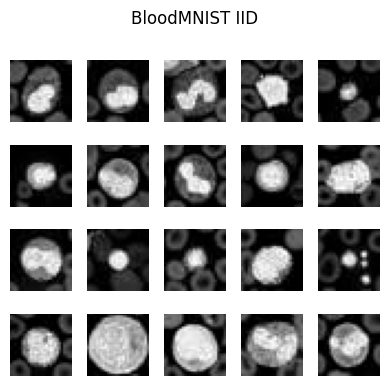

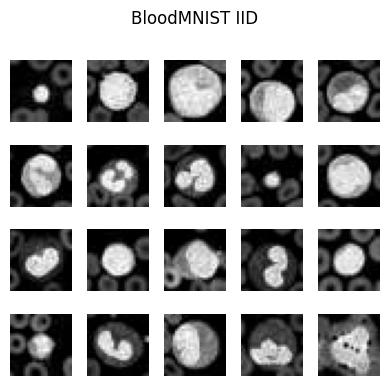

In [123]:
all_labels = []
for loader in bloodmnist_iid_train:
    for images, labels in loader:
        all_labels.append(labels)
        plot_samples((images, labels), 0, title="BloodMNIST IID", plot_name="bloodmnist_iid_train")

for loader in bloodmnist_iid_test:
    for images, labels in loader:
        all_labels.append(labels)
        plot_samples((images, labels), 0, title="BloodMNIST IID", plot_name="bloodmnist_iid_test")

3. Design a convlution neural network to perform classification.  
You can try to adpat previous convolution network.   
Or also you can try this type of architecture :  
- A first 2D convolution layer with an output_channels of 16, a BatchNormalisation and a Relu activation   
- A second 2D conv layer identical but with a MaxPooling layer after  
- A 3rd conv layer with an output_channels of 64, a BatchNormalisation and a Relu activation again.
- A 4rd layer identical to 3rd one.  
- A 5rd layer identical but with a MaxPooling added. Don't forget to use padding to not loose informations from corners.
- Finally add dense layers to perform classification. You can add regularization layers between dropout for example.



In [124]:
class CNN_2(nn.Module):

    def __init__(self):
        super(CNN_2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.batchnorm5 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc2 = nn.Linear(64 * 7 * 7, 8)

    def forward(self, x):

        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.maxpool1(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = self.batchnorm3(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = self.batchnorm5(x)
        x = F.relu(x)
        x = self.maxpool2(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc2(x)

        x = F.softmax(x, dim=1)

        return x

model_0 = CNN_2()

In [125]:
output = model_0(images)

print(output.shape)
print(output)

torch.Size([25, 8])
tensor([[0.2728, 0.1688, 0.0387, 0.1575, 0.1237, 0.0856, 0.0909, 0.0621],
        [0.4380, 0.1079, 0.0194, 0.1125, 0.0423, 0.0810, 0.0324, 0.1665],
        [0.1796, 0.1820, 0.0497, 0.2531, 0.0487, 0.0988, 0.0607, 0.1275],
        [0.2160, 0.2972, 0.0197, 0.1264, 0.0689, 0.1525, 0.0504, 0.0689],
        [0.3194, 0.1180, 0.0342, 0.1055, 0.0831, 0.0975, 0.1145, 0.1278],
        [0.2753, 0.1634, 0.0215, 0.1939, 0.1111, 0.0666, 0.0695, 0.0987],
        [0.1787, 0.1457, 0.0283, 0.1580, 0.1201, 0.0680, 0.0818, 0.2192],
        [0.2151, 0.2157, 0.0375, 0.1468, 0.0692, 0.0396, 0.0614, 0.2147],
        [0.2351, 0.1934, 0.0467, 0.1817, 0.0629, 0.0881, 0.1174, 0.0747],
        [0.2334, 0.1300, 0.0311, 0.1695, 0.0781, 0.0924, 0.0714, 0.1943],
        [0.2372, 0.2416, 0.0267, 0.0925, 0.0925, 0.0981, 0.0829, 0.1285],
        [0.3305, 0.1689, 0.0287, 0.1495, 0.0852, 0.0672, 0.0676, 0.1023],
        [0.1290, 0.2684, 0.0364, 0.0694, 0.0889, 0.0584, 0.1274, 0.2222],
        [0.2471, 0

### Fed training with FedAvg

4. Perform a FedAvg with same parameters as for MNIST datasets. Use 3 clients, etc. Try to run more iterations.

In [126]:
Blood_FedAvg_1 = FedProx(model_0, bloodmnist_iid_train, 1, bloodmnist_iid_test)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.086173852284749 Server Test Accuracy: 9.333333333333332
====> i: 1 Loss: 1.7670023043950398 Server Test Accuracy: 54.33333333333333


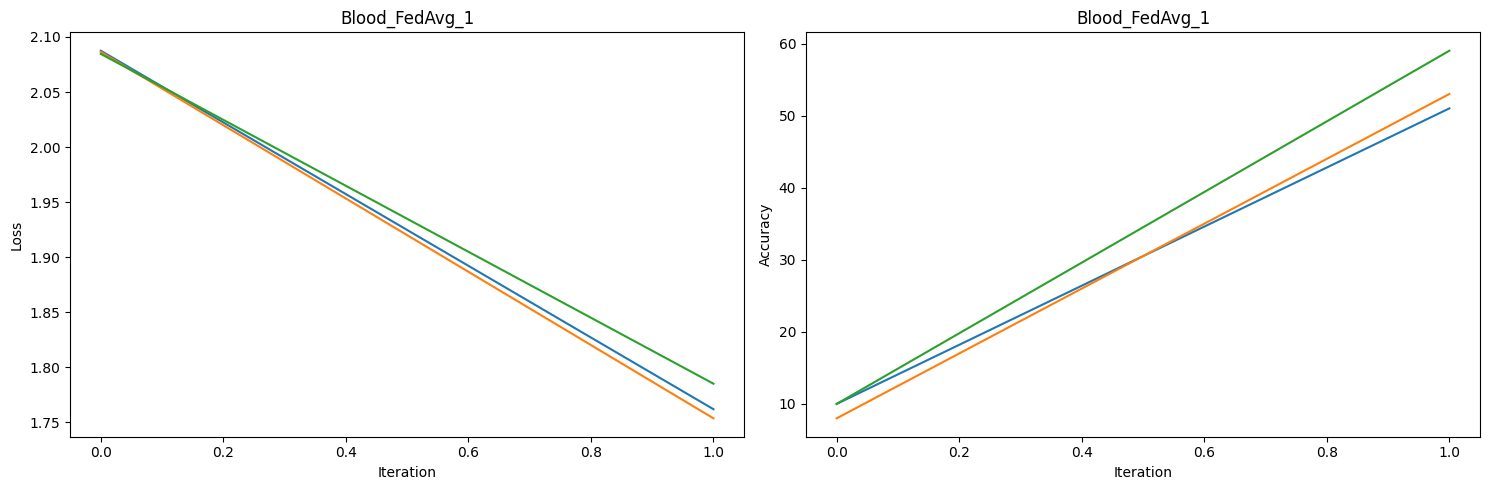

In [127]:
plot_acc_loss("Blood_FedAvg_1", Blood_FedAvg_1[1], Blood_FedAvg_1[2])

### FedPRox

5. As FedAvg perform a FedProx on iid data. Keep the same µ.

In [113]:
# mu = 0 is a FedAvg from the slides so not changing the mu is kinda making exactly the same as above
Blood_FedProx_1 = FedProx(model_0, bloodmnist_iid_train, 1, bloodmnist_iid_test, mu=0.3)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.0687795480092364 Server Test Accuracy: 17.0
====> i: 1 Loss: 1.755001107851664 Server Test Accuracy: 44.33333333333333


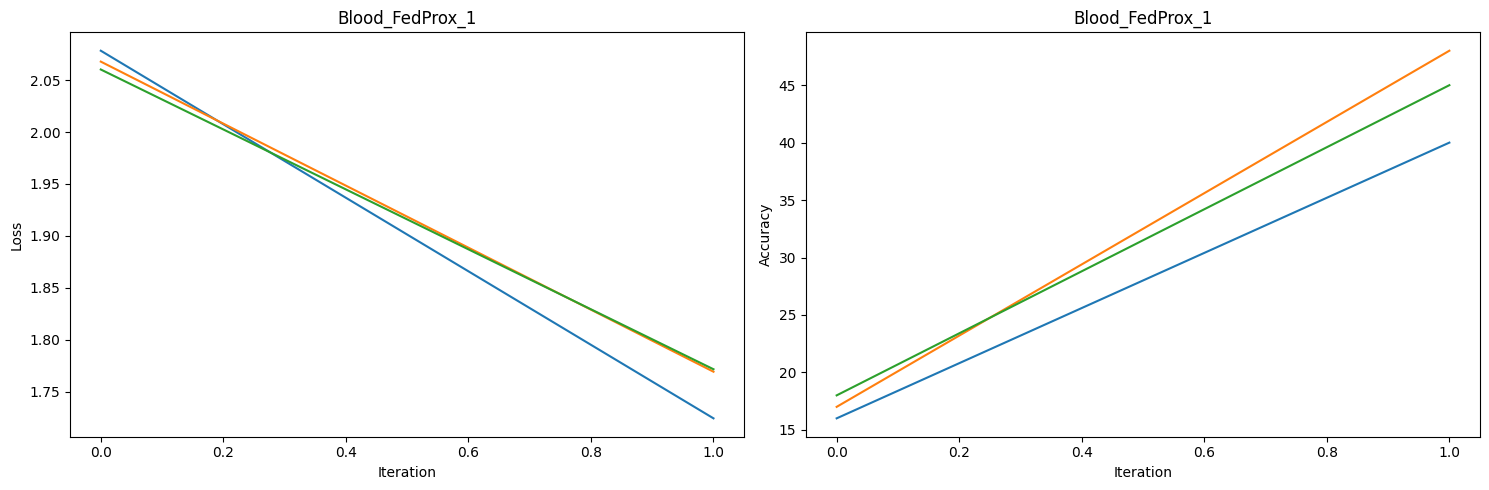

In [115]:
plot_acc_loss("Blood_FedProx_1", Blood_FedProx_1[1], Blood_FedProx_1[2])

### MNIST Non iid

6. Do the same process (FedAVG, FedProx, plot loss and accuracy) but this time on non iid data.

In [141]:
bloodmnist_non_iid_train, bloodmnist_iid_test = get_MNIST(type="non_iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True)

Using downloaded and verified file: ./data/bloodmnist.npz
Using downloaded and verified file: ./data/bloodmnist.npz


AttributeError: ignored

In [ ]:
Blood_FedAvg_3 = FedProx(model_0, bloodmnist_non_iid_train, 1, bloodmnist_non_iid_test)

7. Is results satisfying ? Submit some way to improve results and resolve possible unstabilities. For this you can check original paper : https://arxiv.org/pdf/1812.06127.pdf